In [1]:
# Loading packages
from lmfit import Minimizer, Parameters, report_fit
import seaborn as sns
import scipy as sc
from numpy import exp, log, pi
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

d = pd.read_csv("../Data/ThermRespData.csv")

In [2]:
d = d[d['OriginalTraitValue'] > 0]
sub = d[d['ID'] == 2]
sub

,Input,ID,OrignalTraitName,OriginalTraitDef,StandardisedTraitName,StandardisedTraitDef,OriginalTraitValue,OriginalTraitUnit,OriginalErrorPos,OriginalErrorNeg,...,AcclimVarTempUnit,AcclimVarTempDur,AcclimVarTempDurUnit,LabGrowthTemp,LabGrowthTempUnit,LabGrowthDur,LabGrowthDurUnit,Citation,FigureTable,Notes
5,Richard,2,photosynthetic co2 assimilation,NaN,net photosynthesis rate,NaN,11.203013,micromol m^-2 s^-1,NaN,NaN,...,NaN,NaN,NaN,19,Celsius,NaN,NaN,"Sharkey, T. D., & Loreto, F. (1993). Water str...",3,leaves 2 weeks past full extension
6,Richard,2,photosynthetic co2 assimilation,NaN,net photosynthesis rate,NaN,11.570958,micromol m^-2 s^-1,NaN,NaN,...,NaN,NaN,NaN,19,Celsius,NaN,NaN,"Sharkey, T. D., & Loreto, F. (1993). Water str...",3,leaves 2 weeks past full extension
7,Richard,2,photosynthetic co2 assimilation,NaN,net photosynthesis rate,NaN,10.986789,micromol m^-2 s^-1,NaN,NaN,...,NaN,NaN,NaN,19,Celsius,NaN,NaN,"Sharkey, T. D., & Loreto, F. (1993). Water str...",3,leaves 2 weeks past full extension
8,Richard,2,photosynthetic co2 assimilation,NaN,net photosynthesis rate,NaN,8.152477,micromol m^-2 s^-1,NaN,NaN,...,NaN,NaN,NaN,19,Celsius,NaN,NaN,"Sharkey, T. D., & Loreto, F. (1993). Water str...",3,leaves 2 weeks past full extension
9,Richard,2,photosynthetic co2 assimilation,NaN,net photosynthesis rate,NaN,3.818223,micromol m^-2 s^-1,NaN,NaN,...,NaN,NaN,NaN,19,Celsius,NaN,NaN,"Sharkey, T. D., & Loreto, F. (1993). Water str...",3,leaves 2 weeks past full extension


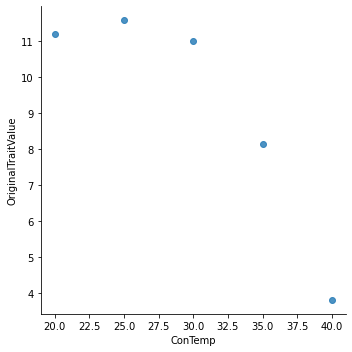

In [3]:
sns.lmplot("ConTemp", "OriginalTraitValue", data = sub, fit_reg = False)

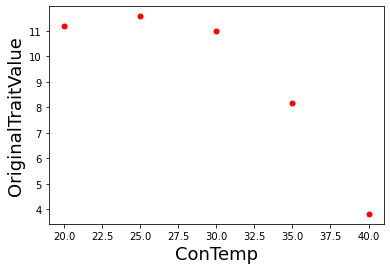

In [4]:
plt.plot(sub['ConTemp'], sub['OriginalTraitValue'], 'r.', markersize = 10, markeredgewidth = 1, label = 'Data')
plt.xlabel('ConTemp', fontsize = 18)
plt.ylabel('OriginalTraitValue', fontsize = 18)
plt.ticklabel_format(style = 'scientific', scilimits = [0, 3])

## Model Fitting

In [5]:
# Fitting three linear model using OLS method
fit_lin = np.polyfit(sub['ConTemp'], sub['OriginalTraitValue'], 1)
fit_quad = np.polyfit(sub['ConTemp'], sub['OriginalTraitValue'], 2)
fit_poly3 =  np.polyfit(sub['ConTemp'], sub['OriginalTraitValue'], 3)
print("OLS for Linear Model: ", fit_lin)
print("OLS for Linear Model: ", fit_quad)
print("OLS for Linear Model: ", fit_poly3)

OLS for Linear Model:  [-0.36376122 20.0591286 ]
OLS for Linear Model:  [-0.03329869  1.63416009 -8.24475669]
OLS for Linear Model:  [-3.65218667e-04 -4.29008571e-04  6.79113281e-01  6.84839714e-01]


In [6]:
# Fitting Briere model using NLLS
# Create object for storing parameters
params_briere = Parameters()

# Add parameters and initial values to it
params_briere.add_many(('B0', 0.01, True, 0, None, None, None),
                       ('T0', 10, True, 0, None, None, None),
                       ('Tm', 40, True, None, None, None, None))

In [7]:
t = sub['ConTemp']
ydata = sub['OriginalTraitValue']

In [8]:
def residuals_briere(params, t, data):
    ''' Model a logistic growth and subtract data '''
    # Get an ordered dictionary of parameter values
    v = params.valuesdict()
    # Briere Model
    model = v['B0'] * t * (t - v['T0']) * (abs(v['Tm'] - t) ** (1/2)) * ((t < v['Tm']).astype(float)) * ((t > v['T0']).astype(float))
    return model - data

In [9]:
# Create minimizer object
minner = Minimizer(residuals_briere, params_briere, fcn_args=(t, ydata))
# Perform the minimisation
fit_briere = minner.minimize()

In [11]:
# report_fit(fit_briere)
fit_briere.residual

array([-3.88088733, -1.640955  ,  0.73993356,  3.28124518, -0.43877206])

In [67]:
len(fit_briere.params)
len(fit_lin)

2

In [68]:
# Calculating the residuals for OLS methods
def residual(fit, t, data):
    # Construct the fitted polynomial equation
    my_fit = np.poly1d(fit)
    
    #Compute predicted values
    ypred = my_fit(t)
    
    # Calculating residuals
    residuals = ypred - data
    return residuals

In [69]:
residuals = residual(fit_lin, t, ydata)
residuals

5    1.580891
6   -0.605860
7   -1.840497
8   -0.824991
9    1.690457
Name: OriginalTraitValue, dtype: float64

In [70]:
def get_AIC(residuals, data, params):
    n = len(data)
    RSS_model = sum(residuals ** 2)
    p_model = len(params)
    return n + 2 + n * log((2 * pi) / n) + n * log(RSS_model) + 2 * p_model

In [71]:
get_AIC(residuals, ydata, fit_lin)

23.550007507061466

In [72]:
def get_BIC(residuals, data, params):
    n = len(data)
    RSS_model = sum(residuals ** 2)
    p_model = len(params)
    return n + 2 + n * log((2 * pi) / n) + n * log(RSS_model) + p_model * log(n)

In [73]:
get_BIC(residuals, ydata, fit_lin)

22.768883331929665

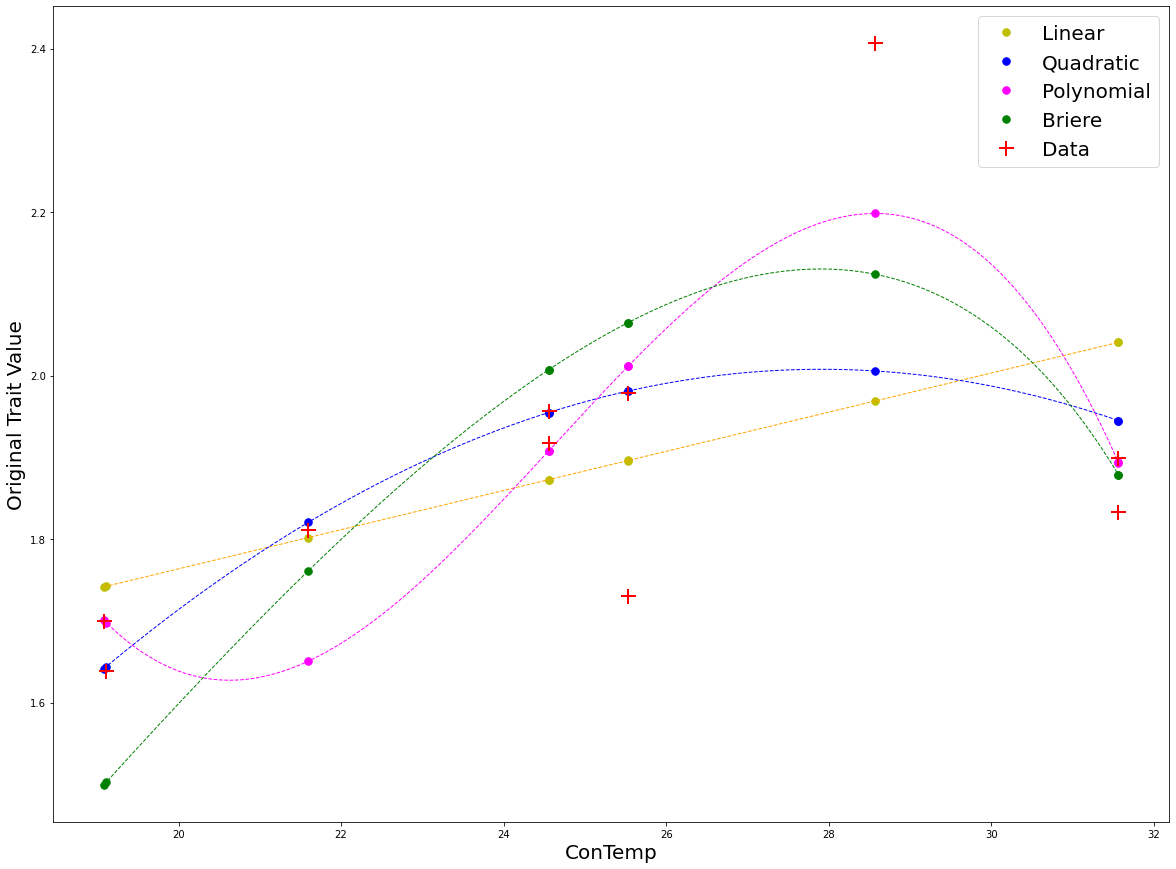

In [102]:
plt.rcParams['figure.figsize'] = [20, 15]
# Linear
result_linear = np.poly1d(fit_lin)(t)
plt.plot(t, result_linear, 'y.', markersize = 15, label = "Linear")
# Get a smooth curve by plugging a time vector to the fitted linear model
t_vec = np.linspace(min(t), max(t), 1000)
ypred_smooth = np.poly1d(fit_lin)(t_vec)
plt.plot(t_vec, ypred_smooth, 'orange', linestyle = '--', linewidth = 1)

# Quadratic
result_quad = np.poly1d(fit_quad)(t)
plt.plot(t, result_quad, 'b.', markersize = 15, label = "Quadratic")
# Get a smooth curve by plugging a time vector to the fitted linear model
t_vec = np.linspace(min(t), max(t), 1000)
ypred_smooth = np.poly1d(fit_quad)(t_vec)
plt.plot(t_vec, ypred_smooth, 'blue', linestyle = '--', linewidth = 1)

# Polynomial
result_poly = np.poly1d(fit_poly3)(t)
plt.plot(t, result_poly, '.', markerfacecolor = 'magenta', markeredgecolor = 'magenta', markersize = 15, label = "Polynomial")
# Get a smooth curve by plugging a time vector to the fitted linear model
t_vec = np.linspace(min(t), max(t), 1000)
ypred_smooth = np.poly1d(fit_poly3)(t_vec)
plt.plot(t_vec, ypred_smooth, 'magenta', linestyle = '--', linewidth = 1)

# Briere Model
result_briere = ydata + fit_briere.residual
plt.plot(t, result_briere, 'g.', markersize = 15, label = 'Briere')
# Get a smooth curve by plugging a time vector to the fitted Gompertz model
t_vec = np.linspace(min(t), max(t), 1000)
N_vec = np.ones(len(t_vec))
residual_smooth_briere = residuals_briere(fit_briere.params, t_vec, N_vec)
plt.plot(t_vec, residual_smooth_briere + N_vec, 'green', linestyle = '--', linewidth = 1)

# Plot data points
plt.plot(t, ydata, 'r+', markersize = 15, markeredgewidth = 2, label = 'Data')

# Plot legend
plt.legend(fontsize = 20)
plt.xlabel('ConTemp', fontsize = 20)
plt.ylabel('Original Trait Value', fontsize = 20)
plt.ticklabel_format(style = 'scientific', scilimits = [0, 3])